# CudaMS

This notebook closely follows the original [matchms tutorial](https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee), but uses our custom CUDA kernel to calculate the CosineGreedy similarity between given pesticide spectra.

For convenience, we are using a colab environment - so that you can run everything in browser.

# Selecting the correct runtime (to access CUDA-enabled GPU)

To compile and use the CUDA kernel, you **need to use a GPU**. To request a free GPU from colab, follow these steps:

In the top right click the black triangle:

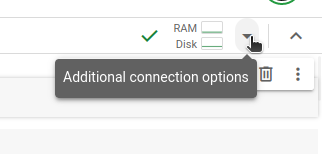

Click "Change runtime type"

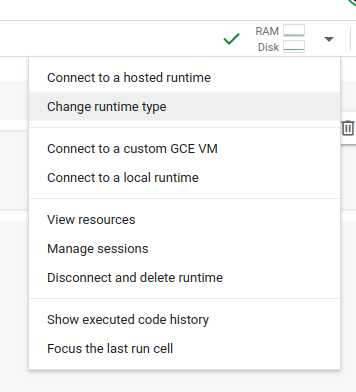

Click "T4 GPU":

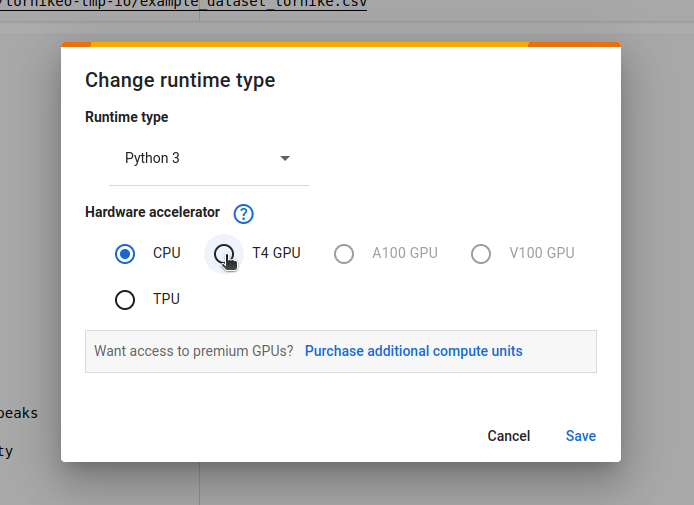

Click "OK" on "Disconnect and delete runtime" (we haven't done much yet, so this is OK)

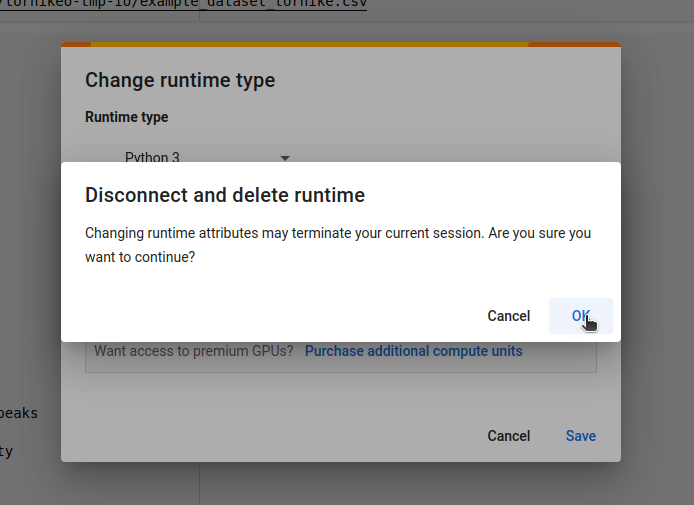

Click "Save"

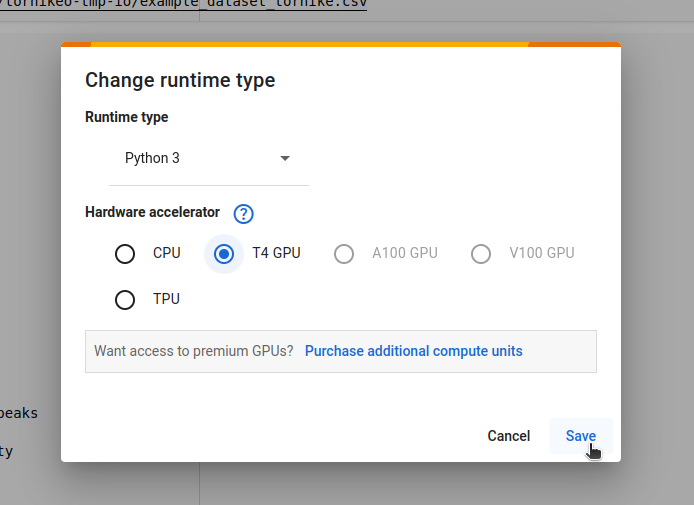

Now you can compile the cuda kernel, and use the `CudaCosineGreedy` just like you would the `CosineGreedy`. 

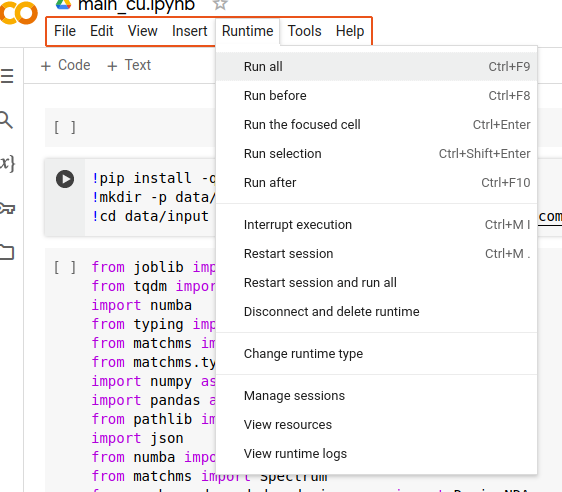

In this cell, we make sure we actually have the GPU available. The kernel code requires an available GPU.

In [ ]:
%load_ext autoreload
%autoreload 2

from numba import cuda; assert cuda.is_available(), "Change the colab instance type to T4."

Install the `cudams` package from github

In [1]:
! pip uninstall cudams -q -y
! pip install git+https://github.com/tornikeo/cosine-similarity.git@main

Import relevant methods and libraries

In [ ]:
from matchms.importing import load_from_mgf
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from cudams.utils import download
from pathlib import Path
from cudams.similarity import CudaCosineGreedy
from numba import cuda
import numpy as np

assert cuda.is_available()

In [3]:
# Download the pesticide.mgf file
pest_file = download('pesticides.mgf')

file = list(load_from_mgf(pest_file))
# Apply filters to clean and enhance each spectrum
spectrums = []

for spectrum in file:
    # Apply default filter to standardize ion mode, correct charge and more.
    # Default filter is fully explained at https://matchms.readthedocs.io/en/latest/api/matchms.filtering.html .
    spectrum = default_filters(spectrum)
    # Scale peak intensities to maximum of 1
    spectrum = normalize_intensities(spectrum)
    spectrums.append(spectrum)

Perform calculations using the using original `matchms` functions.

In [4]:
scores = calculate_scores(references=spectrums,
                          queries=spectrums,
                          similarity_function=CosineGreedy(),
                          is_symmetric=True)
print(f"Size of matrix of computed similarities: {scores.scores.shape}")

# Matchms allows to get the best matches for any query using scores_by_query
query = spectrums[15]  # just an example
best_matches = scores.scores_by_query(query, 'CosineGreedy_score', sort=True)

# Print the calculated scores for each spectrum pair
for (reference, (score, matches)) in best_matches[:10]:
    # Ignore scores between same spectrum
    if reference is not query:
        print(f"Reference scan id: {reference.metadata['scans']}")
        print(f"Query scan id: {query.metadata['scans']}")
        print(f"Score: {score:.4f}")
        print(f"Number of matching peaks: {matches}")
        print("----------------------------")

Size of matrix of computed similarities: (76, 76, 2)
Reference scan id: 613
Query scan id: 2161
Score: 0.8646
Number of matching peaks: 14
----------------------------
Reference scan id: 603
Query scan id: 2161
Score: 0.8237
Number of matching peaks: 14
----------------------------
Reference scan id: 2160
Query scan id: 2161
Score: 0.8015
Number of matching peaks: 25
----------------------------
Reference scan id: 2362
Query scan id: 2161
Score: 0.2923
Number of matching peaks: 7
----------------------------
Reference scan id: 2598
Query scan id: 2161
Score: 0.2231
Number of matching peaks: 5
----------------------------
Reference scan id: 2594
Query scan id: 2161
Score: 0.1761
Number of matching peaks: 3
----------------------------
Reference scan id: 1944
Query scan id: 2161
Score: 0.1396
Number of matching peaks: 5
----------------------------
Reference scan id: 1772
Query scan id: 2161
Score: 0.1037
Number of matching peaks: 4
----------------------------
Reference scan id: 2284
Qu

In [6]:
# Default tolerance and other arguments are the same

cosine_greedy_kernel = CudaCosineGreedy(batch_size=512)
scores_cu = calculate_scores(
    references=spectrums,
    queries=spectrums, 
    similarity_function=cosine_greedy_kernel)

We use the CUDA-calculated results in the same fashion:

In [7]:
# This computed all-vs-all similarity scores, the array of which can be accessed as scores.scores
print(f"Size of matrix of computed similarities: {scores_cu.scores.shape}")

# Matchms allows to get the best matches for any query using scores_by_query
query = spectrums[15]  # just an example
best_matches_cu = scores_cu.scores_by_query(query, 'CudaCosineGreedy_score', sort=True)

Size of matrix of computed similarities: (76, 76, 3)


In [8]:

# Print the calculated scores_cu for each spectrum pair
for (reference, (score, matches, overflow)) in best_matches_cu[:10]:
    # Ignore scores_cu between same spectrum
    if reference != query:
        print(f"Reference scan id: {reference.metadata['scans']}")
        print(f"Query scan id: {query.metadata['scans']}")
        print(f"Score: {score:.4f}")
        print(f"Number of matching peaks: {matches}")
        print(f"Did GPU overflow at this pair: {overflow}")
        print("----------------------------")


Reference scan id: 613
Query scan id: 2161
Score: 0.8646
Number of matching peaks: 14
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 603
Query scan id: 2161
Score: 0.8237
Number of matching peaks: 14
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2160
Query scan id: 2161
Score: 0.8015
Number of matching peaks: 25
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2362
Query scan id: 2161
Score: 0.2923
Number of matching peaks: 7
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2598
Query scan id: 2161
Score: 0.2231
Number of matching peaks: 5
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2594
Query scan id: 2161
Score: 0.1761
Number of matching peaks: 3
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 1944
Query scan id: 2161
Score: 0.1396
Number of matching peaks: 5
Did GPU overflow at this 

We make sure that results from both matchms and CudaCosineGreedy are equal.

In [9]:
for a, b in zip(best_matches[:10], best_matches_cu[:10]):
    reference, (score_a, matches_a) = a
    reference, (score_b, matches_b, overflow_b) = b
    if reference != query:
        # If we didn't overflow
        if not overflow_b:
            assert np.isclose(score_a, score_b), ("score error", score_a, score_b)
            assert np.isclose(matches_a, matches_b), ('match error', matches_a, matches_b)
        # If overflow, score must be leq
        else:
            assert score_a >= score_b
            assert matches_a >= matches_b